In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import trustworthiness
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap



In [34]:
# Function to compute clustering quality metrics
def compute_clustering_metrics(data, method_name):
    kmeans = KMeans(n_clusters=3, random_state=42).fit(data.iloc[:, :2])  # Adjust the number of clusters
    labels = kmeans.labels_
    
    silhouette = silhouette_score(data.iloc[:, :2], labels)
    davies_bouldin = davies_bouldin_score(data.iloc[:, :2], labels)
    calinski_harabasz = calinski_harabasz_score(data.iloc[:, :2], labels)
    
    return {
        'Method': method_name,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Labels': labels,
        'Dates': data['date']
        # 'Dates': pd.to_datetime(data.iloc[:, 2], format='%m/%d/%y')  # Convert dates to datetime for plotting
    }

def plot_clusters(data, method_name, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.title(f'{method_name} Clustering')
    plt.xlabel(f'{method_name} Component 1')
    plt.ylabel(f'{method_name} Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Function to compute trustworthiness
def compute_trustworthiness(original_data, reduced_data, n_neighbors=5):
    return trustworthiness(original_data, reduced_data.iloc[:, :2], n_neighbors=n_neighbors)

# Function to compute Mantel test
def compute_mantel_test(original_data, reduced_data):
    dist_original = pdist(original_data)
    dist_reduced = pdist(reduced_data.iloc[:, :2])
    mantel_result = pearsonr(dist_original, dist_reduced)
    return mantel_result



In [35]:
# Load datasets
pca_data = pd.read_csv('/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/dim-reduction/pca_latent_space.csv')
tsne_data = pd.read_csv('/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/dim-reduction/tsne_latent_space.csv')
vae_data = pd.read_csv('/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/dim-reduction/bestvae2.csv')
umap_data = pd.read_csv('/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/dim-reduction/umap_latent_space.csv')

# Assuming your original data is saved separately
original_data = pd.read_csv("/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/data/data_for_henry_2024.csv")

# Standardize the original data
scaler = StandardScaler()
# original_data.iloc[:, 11:]
original_data_scaled = scaler.fit_transform(original_data.iloc[:, 11:])  # Adjust based on your data structure
# original_data_scaled
vae_data = vae_data.rename(columns={'Date': 'date'})

In [36]:
# Compute clustering metrics
tsne_metrics = compute_clustering_metrics(tsne_data, 't-SNE')
pca_metrics = compute_clustering_metrics(pca_data, 'PCA')
vae_metrics = compute_clustering_metrics(vae_data, 'VAE')
umap_metrics = compute_clustering_metrics(umap_data, 'UMAP')

clustering_metrics = pd.DataFrame([tsne_metrics, pca_metrics, vae_metrics, umap_metrics])
# print("Clustering Quality Metrics:")
# print(clustering_metrics)
'''
higher silhouette score is better, means each point is more similar to own cluster than others
similarly: lower davies-bouldin is better, means each cluster is more different than its most similar cluster (stronger clustering)
higher calinski index also means more well-defined clusters (AKA variance ratio criterion)
wiki: A higher value of CH indicates a better clustering, because it means that the data points are more spread out between clusters than they are within clusters.
## question: does this actually mean anything about our data or that the clustering is accurate/clusters actually existing?
probably? the more accurate you can cluster them.. the more 'real' the clusters are. 
or does this mean PCA is encoding the data in a way that maximizes differences when they might not really be there?
'''


# Compute trustworthiness
tsne_trustworthiness = compute_trustworthiness(original_data_scaled, tsne_data)
pca_trustworthiness = compute_trustworthiness(original_data_scaled, pca_data)
vae_trustworthiness = compute_trustworthiness(original_data_scaled, vae_data)
umap_trustworthiness = compute_trustworthiness(original_data_scaled, umap_data)

trustworthiness_scores = pd.DataFrame({
    'Method': ['t-SNE', 'PCA', 'VAE', 'UMAP'],
    'Trustworthiness': [tsne_trustworthiness, pca_trustworthiness, vae_trustworthiness, umap_trustworthiness]
})
# print("\nTrustworthiness Scores:")
# print(trustworthiness_scores)

'''
higher trustworthiness is better
means OG neighbors are retained in low dimensional space
'''


/Users/henrysun_1/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/henrysun_1/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/henrysun_1/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/henrysun_1/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'\nhigher trustworthiness is better\nmeans OG neighbors are retained in low dimensional space\n'

In [37]:
# Combine all results into a single dataframe
combined_results = pd.merge(clustering_metrics, trustworthiness_scores, on='Method')

# Rearrange columns for better organization (optional)
combined_results = combined_results[['Method', 
                                     'Silhouette Score', 
                                     'Davies-Bouldin Index', 
                                     'Calinski-Harabasz Index', 
                                     'Trustworthiness']]
combined_results = combined_results.round(3)

combined_results


,Method,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Trustworthiness
0,t-SNE,0.507,0.763,190.510,0.655
1,PCA,0.557,0.595,115.297,0.583
2,VAE,0.366,0.924,62.247,0.530
3,UMAP,0.529,0.675,150.551,0.695


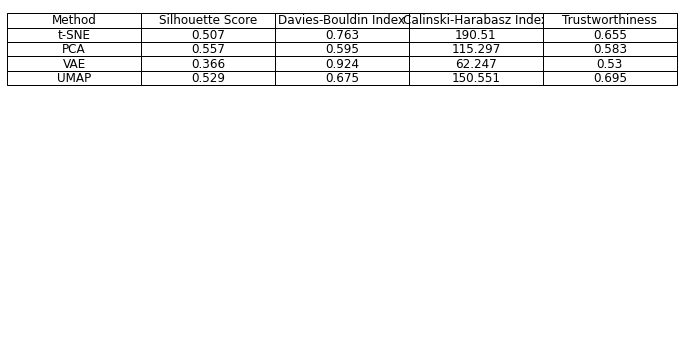

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# Hide axes
ax.axis('off')

# Create a table
table = ax.table(cellText=combined_results.values,
                 colLabels=combined_results.columns,
                 cellLoc='center',
                 loc='upper center')

# Adjust layout
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Save the figure as an image
plt.savefig('combined_results_table.png', bbox_inches='tight', pad_inches=0.5)

# Display the table (optional)
plt.show()

In [39]:
# Function to plot clusters color-coded by dates
def plot_dates(data, method_name, labels, dates):
    plt.figure(figsize=(10, 8))
    
    # Define colors for dates
    date_colors = {'8/1/23': 'orange', '6/1/23': 'blue', '2/1/24': 'green'}  # Adjust colors as needed
    colors = [date_colors[date] for date in dates]
    
    # Plot clusters with boundaries
    for cluster in np.unique(labels):
        cluster_data = data[labels == cluster]
        
        # Scatter plot with date-based colors
        plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=[colors[i] for i in cluster_data.index], label=f'Cluster {cluster}', s=50, alpha=0.8)
        
        # Calculate cluster center and draw ellipse (if needed)
        cluster_center = np.mean(cluster_data.iloc[:, :2], axis=0)
        cov_matrix = np.cov(cluster_data.iloc[:, :2], rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 4 * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=cluster_center, width=width, height=height, angle=angle, edgecolor='black', lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)
    
    # Create legend with date labels
    legend_labels = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10) for date, color in date_colors.items()]
    plt.legend(legend_labels, date_colors.keys(), loc='best')
    
    # Plot settings
    plt.title(f'{method_name} Clustering')
    plt.xlabel(f'{method_name} Component 1')
    plt.ylabel(f'{method_name} Component 2')
    plt.show()
    # plt.savefig('kmeans'f'{method_name}.png', bbox_inches='tight', pad_inches=0.5)


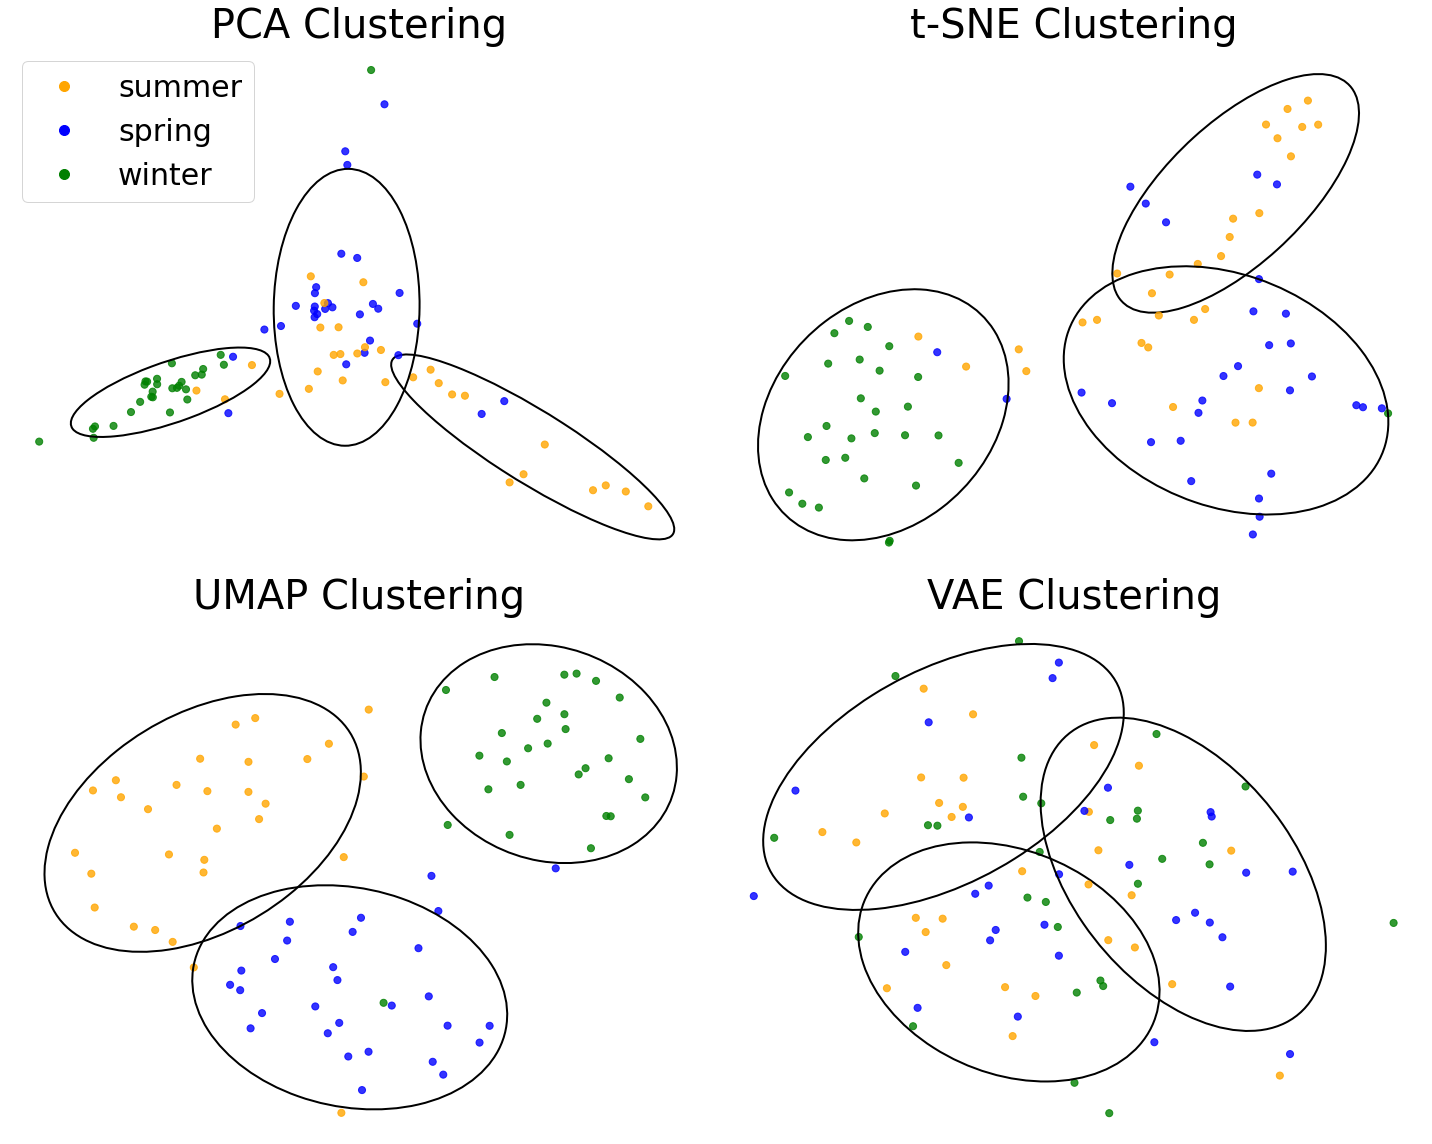

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_dates_subplot(ax, data, method_name, labels, dates, show_legend=False):
    # Define colors for seasons
    date_season_map = {
        '8/1/23': 'summer', 
        '6/1/23': 'spring', 
        '2/1/24': 'winter'
    }
    season_colors = {
        'summer': 'orange', 
        'spring': 'blue', 
        'winter': 'green'
    }
    seasons = [date_season_map[date] for date in dates]
    colors = [season_colors[season] for season in seasons]
    
    # Plot clusters with boundaries
    for cluster in np.unique(labels):
        cluster_data = data[labels == cluster]
        
        # Scatter plot with season-based colors
        ax.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=[colors[i] for i in cluster_data.index], label=f'Cluster {cluster}', s=50, alpha=0.8)
        
        # Calculate cluster center and draw ellipse
        cluster_center = np.mean(cluster_data.iloc[:, :2], axis=0)
        cov_matrix = np.cov(cluster_data.iloc[:, :2], rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 4 * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=cluster_center, width=width, height=height, angle=angle, edgecolor='black', lw=2, facecolor='none')
        ax.add_patch(ellipse)
    
    # Remove axis and labels
    ax.axis('off')
    
    # Set title with big font
    ax.set_title(f'{method_name} Clustering', fontsize=40)  # Increased font size

    # Show legend only if specified
    if show_legend:
        legend_labels = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10) for season, color in season_colors.items()]
        ax.legend(legend_labels, season_colors.keys(), loc='upper left', fontsize=30)  # Adjust font size and position

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot clusters and dates for t-SNE with legend
plot_dates_subplot(axs[0, 1], tsne_data, tsne_metrics['Method'], tsne_metrics['Labels'], tsne_metrics['Dates'])

# Plot clusters and dates for PCA without legend
plot_dates_subplot(axs[0, 0], pca_data, pca_metrics['Method'], pca_metrics['Labels'], pca_metrics['Dates'], show_legend=True)

# Plot clusters and dates for VAE without legend
plot_dates_subplot(axs[1, 1], vae_data, vae_metrics['Method'], vae_metrics['Labels'], vae_metrics['Dates'])

# Plot clusters and dates for UMAP without legend
plot_dates_subplot(axs[1, 0], umap_data, umap_metrics['Method'], umap_metrics['Labels'], umap_metrics['Dates'])

# Adjust layout
plt.tight_layout()
plt.show()
# plt.savefig('all_clusters.png', bbox_inches='tight', pad_inches=0.5)


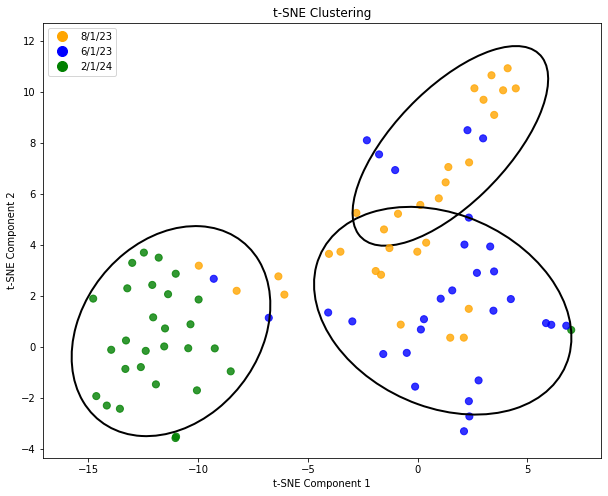

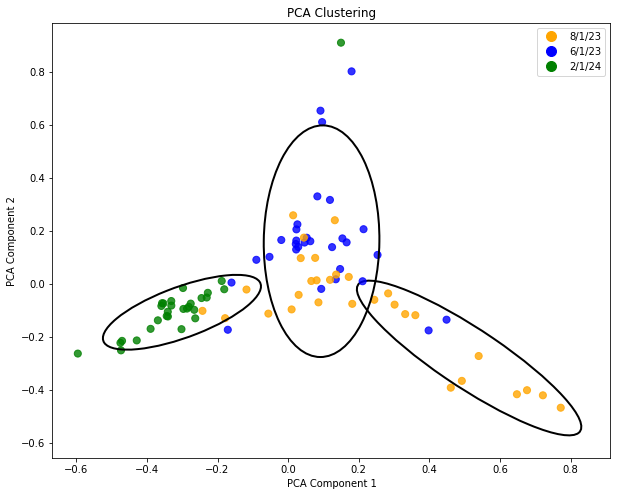

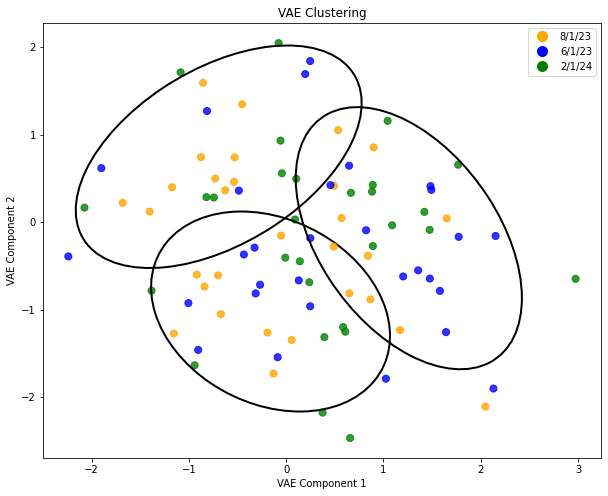

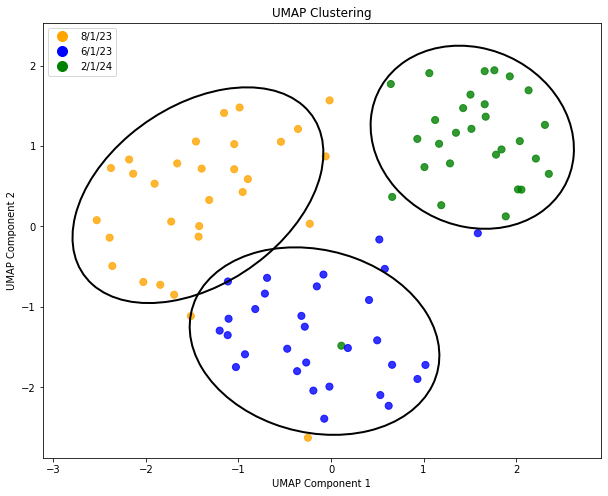

In [41]:
# Plot clusters and dates for t-SNE
plot_dates(tsne_data, tsne_metrics['Method'], tsne_metrics['Labels'], tsne_metrics['Dates'])

# Plot clusters and dates for PCA
plot_dates(pca_data, pca_metrics['Method'], pca_metrics['Labels'], pca_metrics['Dates'])

# Plot clusters and dates for VAE
plot_dates(vae_data, vae_metrics['Method'], vae_metrics['Labels'], vae_metrics['Dates'])

# Plot clusters and dates for UMAP
plot_dates(umap_data, umap_metrics['Method'], umap_metrics['Labels'], umap_metrics['Dates'])


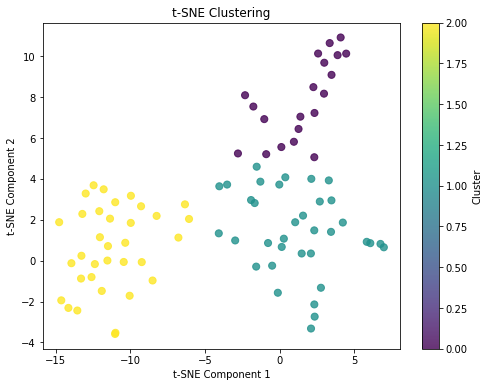

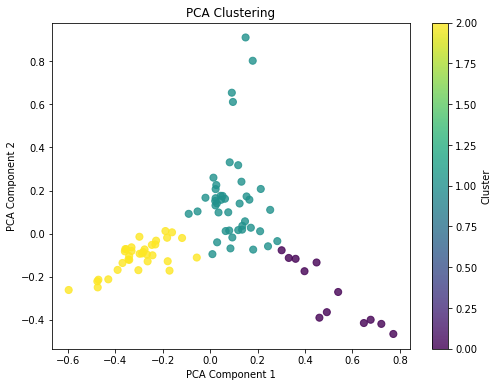

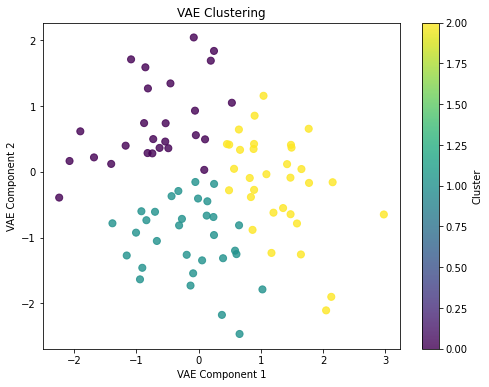

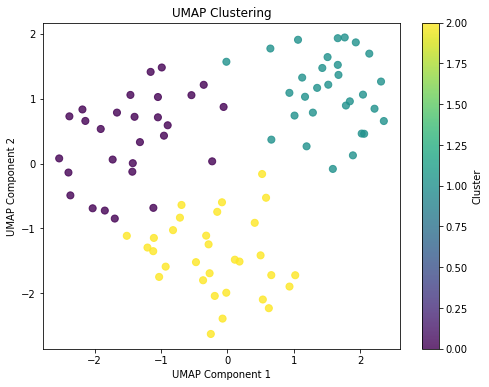

In [42]:
plot_clusters(tsne_data, tsne_metrics['Method'], tsne_metrics['Labels'])
plot_clusters(pca_data, pca_metrics['Method'], pca_metrics['Labels'])
plot_clusters(vae_data, vae_metrics['Method'], vae_metrics['Labels'])
plot_clusters(umap_data, umap_metrics['Method'], umap_metrics['Labels'])